# Assignment 3 - MBAN 6110

Darren Singh - 216236275

In [4]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error

# General Flow of the Assignment   

Each cell assumes that only the ones before it have been run.    

Each part is completed in sequence (Part 1, then Part 2, then Part 3).    

The answer for each part will appear in a markdown cell, which will then be followed by the supporting code.

# Part 1 - Data Cleaning

Initially it may seem odd to notice decimal numbered floors and bathrooms, however these represent half and three quater baths along with lofts.    

No null values or duplicates were found in the dataset, the sale date column was converted to the data type datetime.    

* The sale month, year and day were extracted from the sale date column as regression models cannot handle datetime data.

* The id column will not be passed to the regression model as it should have no impact on the price of the house.

A categorical column was created to act as a binary identifier for whether or not a house was renovated. The creation of dummy variables will be handled via one hot encoding when the data pipeline is being built.    

Dimensionality reduction was not applied to the dataset because there are not an overly large amount of columns / dimensions. The effort / extra computation time it would require would likely not be worth what little performance gains it could offer in this case.    

Since regression models are sensitive to outliers, a box plot was created for each numerical variable and any obviuos outliers were removed from the data.

To begin regression modelling, a ride regression was used:

* This was chosen because it utilizes L2 regularization, a process that will trend the coefficients of features that have lower impacts on the model towards 0, but will not remove them. This will be a starting point for feature selection. 

* First, the target and input features must be defined. The target feature is price and the input features are initially every column of the dataset (split into categorical and numerical data) except for the id column. 

* Second a data pipeline is built. This will handle the one hot encoding of the categorical features and perform a Min-Max scaling on the numerical data to allow it to be processed by the regression models.

* Third, a ridge regression is applied. The model is fit and predictions are created. The RMS error of the model is printed as well as the RMS of the coefficicents with the features and their corresponding coefficients. The features with smaller coefficients than the others (less than half the RMS of the coefficicents are dropped), and this process is repreated 3 more times after which the final feature set has been found.

* Using a ridge regression for feature selection was the best fit for this data because I had no insights going into it. Just by looking at the columns it is difficult to make any predictions about which columns could have a great impact on the price of the house. I chose ridge regression over Lasso or ElasticNet since it does not delete features. I would like to be able to follow the process and review the columns that model deems irrelevant, as opposed to having them just removed and the model fit around them.

In [5]:
# read in data

# UPDATE PATH AS NEEDED
data = pd.read_csv("C:\\Users\\darre\\Downloads\\kc_house_data.csv")

# display all columns
pd.set_option('display.max_columns', None)

data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [6]:
# check all the columns

data.describe(include='all')

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,21613,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
unique,NaN,372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,20140623T000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,4.580302e+09,NaN,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,NaN,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,NaN,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,NaN,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,NaN,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,NaN,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000


In [7]:
# notice that there is an entry with 33 bedrooms, there is also a house that cost 7.7mil so this is plausible
# might need to drop this entry when doing linear regression since it is large

# decimal amounts of floors are allowed

# A 0.5 decimal of bathrooms is allowed, 2.5 bathrooms means 2 full and 1 half bathroom
# https://realestatechuck.com/bathrooms-defined/#:~:text=Two%20and%20a%20half%20baths&text=So%2C%20to%20break%20it%20down,quarter%20bathroom%2C%20and%20a%20half

# to get these insights im looking at the max values from the output of the describe above
# most of the columns max values are plausible for an expensive house

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [9]:
# appears to be no null values, will check for duplicates

doubled = data.duplicated()

for val in doubled:
    if val == True:
        print(val)

# No duplicates found

In [10]:
# should convert the date column to dtype datetime

data['date'] = pd.to_datetime(data['date'])

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21613 non-null  int64         
 1   date           21613 non-null  datetime64[ns]
 2   price          21613 non-null  float64       
 3   bedrooms       21613 non-null  int64         
 4   bathrooms      21613 non-null  float64       
 5   sqft_living    21613 non-null  int64         
 6   sqft_lot       21613 non-null  int64         
 7   floors         21613 non-null  float64       
 8   waterfront     21613 non-null  int64         
 9   view           21613 non-null  int64         
 10  condition      21613 non-null  int64         
 11  grade          21613 non-null  int64         
 12  sqft_above     21613 non-null  int64         
 13  sqft_basement  21613 non-null  int64         
 14  yr_built       21613 non-null  int64         
 15  yr_renovated   2161

In [11]:
# dummy variables next

# majority of it will be taken care via one hot encoding in pipeline

# could add a column to represent whether or not the house was modified, could be something of interest

# create column that is 1 if the house has ever had renovations done on it
data['renovated'] = (data['yr_renovated'] > 0).astype(int)
data.describe()


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,renovated
count,2.161300e+04,21613,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,2014-10-29 04:38:01.959931648,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652,0.042289
min,1.000102e+06,2014-05-02 00:00:00,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,0.000000
25%,2.123049e+09,2014-07-22 00:00:00,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000,0.000000
50%,3.904930e+09,2014-10-16 00:00:00,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000,0.000000
75%,7.308900e+09,2015-02-17 00:00:00,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000,0.000000
max,9.900000e+09,2015-05-27 00:00:00,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,1.000000
std,2.876566e+09,NaN,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631,0.201253


In [12]:
# irrelevant columns

# could consider dropping the final two
# not sure if info about the neighbours is relevant

# will let it remain for now because it COULD be useful, if the regression models deem it useless then I will drop it

# can drop id, not important for regression. Or just don't pass it to the models

# regression models can not handle datetime, need to convert to dummy variables or extract relevant into
# could just extract month and year, extracting day could be too granular, not sure
# will include day and let the model deem if it is useless
# these are categorical columns, ratio between 2 years does not really mean anything value wise like a scale would

data['sale_year'] = pd.DatetimeIndex(data['date']).year
data['sale_month'] = pd.DatetimeIndex(data['date']).month
data['sale_day'] = pd.DatetimeIndex(data['date']).day
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,renovated,sale_year,sale_month,sale_day
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,0,2014,10,13
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,1,2014,12,9
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,0,2015,2,25
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,0,2014,12,9
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,0,2015,2,18


In [13]:
# probably don't need to consider dimensionality reduction because there isn't a crazy number of columns

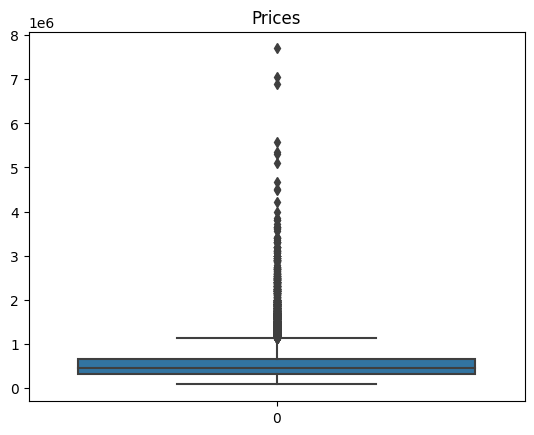

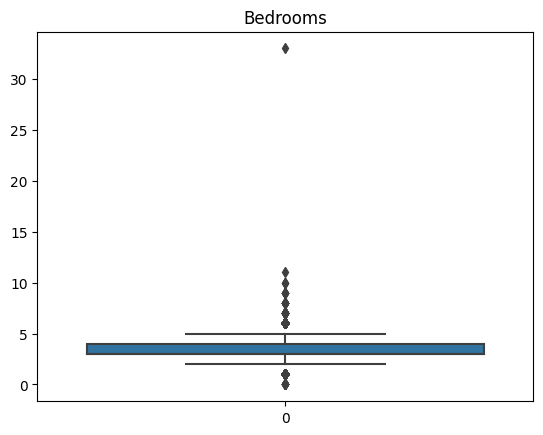

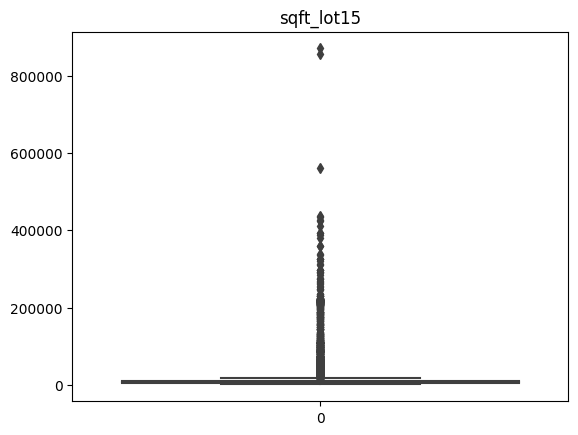

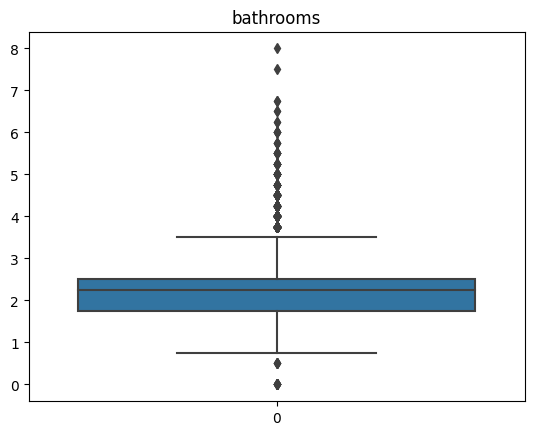

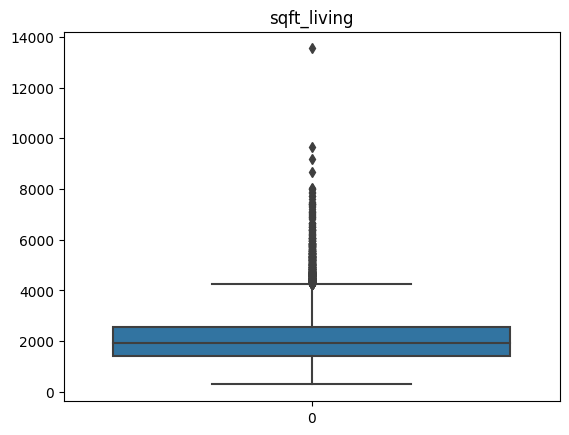

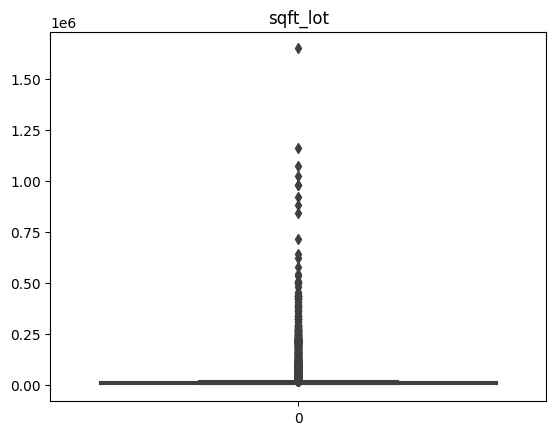

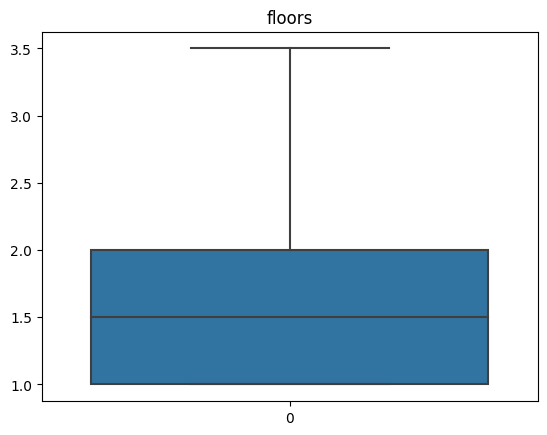

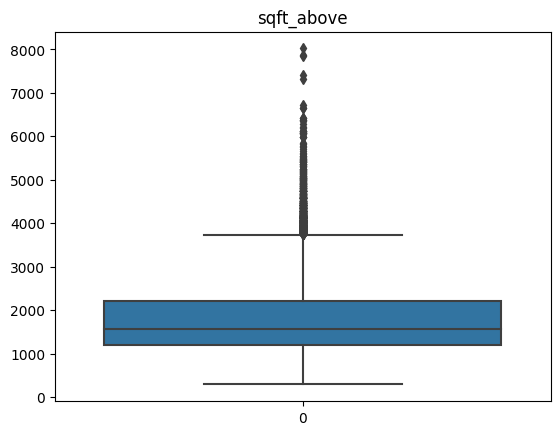

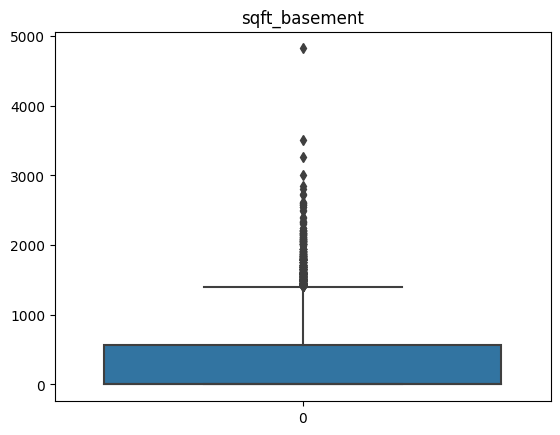

In [14]:
# check for outliers 

# CELL OUTPUT COLLAPSED - MANY PLOTS

# check all numerical columns for outliers
# remove outliers because regression is sensitive to them

# boxplot price 
sns.boxplot(data['price'])
# few entries seem to be outliers, drop them since regression sensitive to outliers
# would pull the line in one direction a lot
# drop all records with prices > 6mil
plt.title('Prices')
plt.show()
data = data[data['price'] <= 6e6]

# check bedrooms
sns.boxplot(data['bedrooms'])
plt.title('Bedrooms')
plt.show()
# drop entry that has 33 bedrooms
data = data[data['bedrooms'] < 30]

sns.boxplot(data['sqft_lot15'])
plt.title('sqft_lot15')
plt.show()
# drop entries exceeding 5e5
data = data[data['sqft_lot15'] < 5e5]

sns.boxplot(data['bathrooms'])
plt.title('bathrooms')
plt.show()
# looks good, no need for action

sns.boxplot(data['sqft_living'])
plt.title('sqft_living')
plt.show()
# drop one outlier exceeding 12,000
data = data[data['sqft_living'] < 12000]

sns.boxplot(data['sqft_lot'])
plt.title('sqft_lot')
plt.show()
# drop one outlier, exceeding 1.5e6
data = data[data['sqft_lot'] < 1.5e6]

sns.boxplot(data['floors'])
plt.title('floors')
plt.show()
# looks good, no need for action

# view, condition, grade are all bounded

sns.boxplot(data['sqft_above'])
plt.title('sqft_above')
plt.show()
# looks good, no need for action

sns.boxplot(data['sqft_basement'])
plt.title('sqft_basement')
plt.show()
# drop one outlier exceeding 4000
data = data[data['sqft_basement'] < 4000]

# won't check long and lat, they are coordinates

In [15]:
# start of part 2 

# grab the target
target = ['price']

# grab inputs (start with the entire dataset, split between cateogorical and numerical)
# wont pass ID, it is irrelevant for model
# long/lat would be numerical, they are decimals and ratios of them are meaningful
# not sure how long/lat will respond to minmax scaling, it might mean that thye only have meaning relative to ohter values (how far houses are from the average long/lat)
# hopefully it is deemed not useful and is dropped 
# view and grade would be categorical, they are discrete and have limited values. magnitude of difference between ranks is not necessarily uniform
catFeatures = ['sale_year', 'sale_month', 'sale_day', 'waterfront', 'yr_built', 'yr_renovated', 'zipcode', 'renovated', 'grade', 'view', 'condition']
numFeatures = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

# split into training and testing (70/30 split)
X_train, X_test, y_train, y_test = train_test_split(data[catFeatures + numFeatures], data[target], test_size=0.3, random_state=1)

In [16]:
# define transformers

# apply one hot encoding to categorical features
# apply min max scaling to numerical features

# no need to specify filling of missing values for numerical, there isnt any missing data
# no need to handle unknown for categorical because there isnt any in data
# can include the handling for completeness

catTransformer = Pipeline(steps = [('onehot', OneHotEncoder(handle_unknown='ignore'))])
numTransformer = Pipeline(steps = [('scaler', MinMaxScaler())])

In [17]:
# build preprocessor
preprocessor = ColumnTransformer(transformers = [('cat', catTransformer, catFeatures), ('num', numTransformer, numFeatures)])


In [18]:
# apply ridge to begin with to select features
ridgeRegression = Pipeline(steps = [('preprocessor', preprocessor), ('regressor', Ridge(alpha=1.0))])

In [19]:
# perform the fit
ridgeRegression.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sale_year', 'sale_month',
                                                   'sale_day', 'waterfront',
                                                   'yr_built', 'yr_renovated',
                                                   'zipcode', 'renovated',
                                                   'grade', 'view',
                                                   'condition']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['bedrooms', 'bathrooms',
                                                   'sqft_living', 'sqft_lot',
                                                   'floors', 'sqft_above',
                                                   'sqft_basement', 'lat',
                                                   'long', 'sqft_living15',
                                                   'sqft_lot15'])])),
                ('regressor', Ridge())])

In [20]:
# grab predictions

pred = ridgeRegression.predict(X_test)

print("RMS of Model Error:", np.sqrt(mean_squared_error(pred, y_test)))

# grab coefficients from ridge regression
coefs = ridgeRegression.named_steps['regressor'].coef_

# grab the preprocessor step, from within the preprocessor grab the transformer (use _ to get features after fitting was done)
features = ridgeRegression.named_steps['preprocessor'].transformers_[0][1].named_steps['onehot'].get_feature_names_out()
# add in the numerical features
numFeatures = np.array(numFeatures)
features = np.concatenate((features, numFeatures))

# get rms of coefs, use rms since there are negative values
# .coef_ returns a 2d array with an empty 1st dimension, convert it to a 1d array for zip with np.reshape
coefs = coefs.reshape(len(coefs[0]))
print("RMS of coefficients:", np.sqrt(np.mean(coefs**2)))

# zip them together so I can see what coefficient corresponds to what feature
linked = zip(features, coefs)

# check the coefficient of each feature
for feature, coef in linked:
    # 50000 was chosen as a threshold since it is less than half the RMS
    # only absolute values are considered because a large negative is significant, represents negative correlation
    if abs(coef) < 50000:
        print(feature, coef)

# from this output we see that the sale date, year the house was built, year it was renovated and whether or not it was renovated have relative lower coefficients
# now we remove these features from the feature list, repeat the pipeline and evalulate the results again

# dont drop zipcode or view yet because not all the columns are included

RMS of Model Error: 150165.42780427268
RMS of coefficients: 137461.603150274
sale_year_2014 -30126.65400261811
sale_year_2015 30126.65399911862
sale_month_1 -39447.45305690915
sale_month_2 -36488.21995106099
sale_month_3 -17928.180230433107
sale_month_4 -5839.976164811977
sale_month_5 7611.256669065971
sale_month_6 13859.012126381635
sale_month_7 14963.340786566501
sale_month_8 16690.730014448443
sale_month_9 7405.696809390637
sale_month_10 10478.435364245981
sale_month_11 15586.209313037967
sale_month_12 13109.148317868883
sale_day_1 5558.761874842207
sale_day_2 11596.250243098404
sale_day_3 3956.04824581308
sale_day_4 2490.1771473698313
sale_day_5 -3509.625470559997
sale_day_6 -2951.4105304011646
sale_day_7 -3238.77860888844
sale_day_8 1665.9743714980023
sale_day_9 -3618.4390790098846
sale_day_10 -1106.8460717128753
sale_day_11 -4072.431027555449
sale_day_12 -11357.861486764092
sale_day_13 10623.747604953653
sale_day_14 5737.423656379729
sale_day_15 -3877.814879429757
sale_day_16 -14

In [21]:
# remove columns and rebuild pipeline

catFeatures = ['waterfront', 'zipcode', 'view', 'grade', 'condition']
numFeatures = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

# split into training and testing (70/30 split)
X_train, X_test, y_train, y_test = train_test_split(data[catFeatures + numFeatures], data[target], test_size=0.3, random_state=1)

# build preprocessor
preprocessor = ColumnTransformer(transformers = [('cat', catTransformer, catFeatures), ('num', numTransformer, numFeatures)])

# apply ridge to begin with to select features
ridgeRegression = Pipeline(steps = [('preprocessor', preprocessor), ('regressor', Ridge(alpha=1.0))])

# perform the fit
ridgeRegression.fit(X_train, y_train)

# grab predictions
pred = ridgeRegression.predict(X_test)
print("Root Mean Square Error",np.sqrt(mean_squared_error(pred, y_test)))

# grab coefficients from ridge regression
coefs = ridgeRegression.named_steps['regressor'].coef_

# grab the preprocessor step, from within the preprocessor grab the transformer (use _ to get features after fitting was done)
features = ridgeRegression.named_steps['preprocessor'].transformers_[0][1].named_steps['onehot'].get_feature_names_out()
# add in the numerical features
numFeatures = np.array(numFeatures)
features = np.concatenate((features, numFeatures))

# get rms of coefs
# .coef_ returns a 2d array with an empty 1st dimension, convert it to a 1d array for zip with np.reshape
coefs = coefs.reshape(len(coefs[0]))
print("RMS of coefficients", np.sqrt(np.mean(coefs**2)))

# zip them together so I can see what coefficient corresponds to what feature
linked = zip(features, coefs)

# check the coefficient of each feature
for feature, coef in linked:
    # 50000 was chosen as a threshold as it is less than half the RMS of the coefficients
    # checking absolute values only, large negative is still significant, represents a negative correlation
    if abs(coef) < 50000:
        print(feature, coef)

# from this iteration we see that zipcode is has smaller coefficients and should be dropped
# view and condition will not be dropped since their entire value ranges are not present
# in the next iteration it will be dropped and the model will be retested

Root Mean Square Error 151842.53835229733
RMS of coefficients 236338.10901926685
zipcode_98010 -35434.569099958826
zipcode_98024 3798.4210442234853
zipcode_98027 8830.02758924816
zipcode_98034 -48268.585392372304
zipcode_98045 12265.213499580805
zipcode_98052 18559.145758070084
zipcode_98053 7465.781434590628
zipcode_98065 -31716.446015239737
zipcode_98074 -15515.739044437436
zipcode_98075 -9161.517674423183
zipcode_98118 -35546.80047070008
zipcode_98126 -30106.22209701552
zipcode_98136 31330.941927544725
zipcode_98177 -48858.82411425854
view_1 -31931.20669692444
view_3 10925.295671835935
condition_2 -17905.77874625096
condition_3 5256.417776466739
condition_4 31903.547313369054
sqft_lot15 896.4480183563426


In [22]:
# remove columns and rebuild pipeline

catFeatures = ['waterfront', 'view', 'grade', 'condition']
numFeatures = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

# split into training and testing (70/30 split)
X_train, X_test, y_train, y_test = train_test_split(data[catFeatures + numFeatures], data[target], test_size=0.3, random_state=1)

# build preprocessor
preprocessor = ColumnTransformer(transformers = [('cat', catTransformer, catFeatures), ('num', numTransformer, numFeatures)])

# apply ridge to begin with to select features
ridgeRegression = Pipeline(steps = [('preprocessor', preprocessor), ('regressor', Ridge(alpha=1.0))])

# perform the fit
ridgeRegression.fit(X_train, y_train)

# grab predictions
pred = ridgeRegression.predict(X_test)
print("Root Mean Square Error",np.sqrt(mean_squared_error(pred, y_test)))

# grab coefficients from ridge regression
coefs = ridgeRegression.named_steps['regressor'].coef_

# grab the preprocessor step, from within the preprocessor grab the transformer (use _ to get features after fitting was done)
features = ridgeRegression.named_steps['preprocessor'].transformers_[0][1].named_steps['onehot'].get_feature_names_out()
# add in the numerical features
numFeatures = np.array(numFeatures)
features = np.concatenate((features, numFeatures))

# get rms of coefs
# .coef_ returns a 2d array with an empty 1st dimension, convert it to a 1d array for zip with np.reshape
coefs = coefs.reshape(len(coefs[0]))
print("RMS of coefficients", np.sqrt(np.mean(coefs**2)))

# zip them together so I can see what coefficient corresponds to what feature
linked = zip(features, coefs)

# check the coefficient of each feature
for feature, coef in linked:
    # 50000 was chosen as a threshold as it is less than half the RMS of the coefficients
    # checking absolute values only, large negative is still significant, represents a negative correlation
    if abs(coef) < 50000:
        print(feature, coef)

# can consider dropping floors since it is a small coefficient
# will not drop view, condition or grade because their entire value range is not listed
# Will drop floor and see if the RMS error shrinks, if it does not then floors will be kept

Root Mean Square Error 197455.7659655484
RMS of coefficients 349604.795608706
view_1 17396.856150182717
view_3 -2317.4655816198074
grade_10 -31191.68822005471
condition_2 -25712.44198587264
condition_3 -23496.307863336915
condition_4 34914.08892873293
floors 1226.079066755357


In [23]:
# remove columns and rebuild pipeline

catFeatures = ['waterfront', 'view', 'grade', 'condition']
numFeatures = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

# split into training and testing (70/30 split)
X_train, X_test, y_train, y_test = train_test_split(data[catFeatures + numFeatures], data[target], test_size=0.3, random_state=1)

# build preprocessor
preprocessor = ColumnTransformer(transformers = [('cat', catTransformer, catFeatures), ('num', numTransformer, numFeatures)])

# apply ridge to begin with to select features
ridgeRegression = Pipeline(steps = [('preprocessor', preprocessor), ('regressor', Ridge(alpha=1.0))])

# perform the fit
ridgeRegression.fit(X_train, y_train)

# grab predictions
pred = ridgeRegression.predict(X_test)
print("Root Mean Square Error",np.sqrt(mean_squared_error(pred, y_test)))

# grab coefficients from ridge regression
coefs = ridgeRegression.named_steps['regressor'].coef_

# grab the preprocessor step, from within the preprocessor grab the transformer (use _ to get features after fitting was done)
features = ridgeRegression.named_steps['preprocessor'].transformers_[0][1].named_steps['onehot'].get_feature_names_out()
# add in the numerical features
numFeatures = np.array(numFeatures)
features = np.concatenate((features, numFeatures))

# get rms of coefs
# .coef_ returns a 2d array with an empty 1st dimension, convert it to a 1d array for zip with np.reshape
coefs = coefs.reshape(len(coefs[0]))
print("RMS of coefficients", np.sqrt(np.mean(coefs**2)))

# zip them together so I can see what coefficient corresponds to what feature
linked = zip(features, coefs)

# check the coefficient of each feature
for feature, coef in linked:
    # 50000 was chosen as a threshold as it is less than half the RMS of the coefficients
    # checking absolute values only, large negative is still significant, represents a negative correlation
    if abs(coef) < 50000:
        print(feature, coef)

# minimal gains from dropping floor, doesn't really make a difference whether or not it is included, so it will be included
# will not drop view, condition or grade because their entire value range is not listed

Root Mean Square Error 197458.06986814734
RMS of coefficients 354728.8769873966
view_1 17368.612037074337
view_3 -2305.576245827245
grade_10 -31129.48021954941
condition_2 -25731.576698536806
condition_3 -23455.335600215258
condition_4 34883.97237850123


# Part 2 - Model Selection

Using the final feature set a Simple Linear, Ridge, Lasso and ElasticNet Regression were performed on the data. 

Each of these models were fit, predictions were generated and their RMS Error was determined as well as the RMS Error as a percentage of the mean house price.   

For the ridge regression model the features with the largest coefficients were printed, this information will be used in part 3.   

It was found that the best model is a Simple Linear Regression. All of the models have RMS Errors within 0.1% of each other, meaning they perform similarly. The Simple Linear Regression was chosen because it is the least computationally expensive of the models, and given that they all perform the same, computational efficiency should be optimized. If further testing was done to optimize the hyper parameters of the other models perhaps they could achieve better results, but given the tools I am familiar with, the mean squared error is the best performance indicator. And going solely off the mean squared error, the Simple Linear Regression is the best model.

In [24]:
# now to test different regression models and compare their RMS errors
# also useful to compare their RMS Errors as a percent of mean house price

# select final feature sets
catFeatures = ['waterfront', 'view', 'grade', 'condition']
numFeatures = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

# split into training and testing (70/30 split)
X_train, X_test, y_train, y_test = train_test_split(data[catFeatures + numFeatures], data[target], test_size=0.3, random_state=1)

# build preprocessor
preprocessor = ColumnTransformer(transformers = [('cat', catTransformer, catFeatures), ('num', numTransformer, numFeatures)])

In [25]:
# do the final ridge regression

ridgeRegression = Pipeline(steps = [('preprocessor', preprocessor), ('regressor', Ridge(alpha=1.0))])

# perform the fit
ridgeRegression.fit(X_train, y_train)

# grab predictions
pred = ridgeRegression.predict(X_test)
print("Root Mean Square Error:", np.sqrt(mean_squared_error(pred, y_test)))

# normalize by mean house price
meanPrice = data['price'].mean()
print("RMS Error as percentage of Mean House Price", (np.sqrt(mean_squared_error(pred, y_test)) / meanPrice) * 100)

# grab coefficients from ridge regression
coefs = ridgeRegression.named_steps['regressor'].coef_

# grab the preprocessor step, from within the preprocessor grab the transformer (use _ to get features after fitting was done)
features = ridgeRegression.named_steps['preprocessor'].transformers_[0][1].named_steps['onehot'].get_feature_names_out()
# add in the numerical features
numFeatures = np.array(numFeatures)
features = np.concatenate((features, numFeatures))

# get rms of coefs
# .coef_ returns a 2d array with an empty 1st dimension, convert it to a 1d array for zip with np.reshape
coefs = coefs.reshape(len(coefs[0]))
print("RMS of coefficients", np.sqrt(np.mean(coefs**2)))

# zip them together so I can see what coefficient corresponds to what feature
linked = zip(features, coefs)

# print features with the largest coefficients to see which are most relevant
for feature, coef in linked:
    # checking absolute values only, large negative is still significant, represents a negative correlation
    # display the coefficients as a percentange of the sum of coefficients, representing how much each feature contributes to the model (weighting as a percentage)
    if abs(coef) > 100000:
        print(feature, (coef/np.sum(abs(coefs)) * 100))

Root Mean Square Error: 197455.7659655484
RMS Error as percentage of Mean House Price 36.64742936025074
RMS of coefficients 349604.795608706
waterfront_0 -2.4752267435218673
waterfront_1 2.4752267435218163
view_0 -1.599348893927428
view_4 2.124583111382272
grade_1 -1.5490228927631566
grade_3 -1.6366288558814965
grade_4 -4.02794529775263
grade_5 -4.540903085786034
grade_6 -4.600747199993767
grade_7 -4.365559066818662
grade_8 -3.7487641375529526
grade_9 -2.3161166196831577
grade_11 2.3865533216526296
grade_12 7.767845384429058
grade_13 17.008275110797243
bedrooms -1.4218522975159067
bathrooms 1.5606581365108543
sqft_living 6.657353293268084
sqft_lot 2.357754605905039
sqft_above 6.640083021535467
sqft_basement 2.7969295092680446
lat 4.767022590167151
long -3.1148882653511083
sqft_living15 2.135226453211244
sqft_lot15 -1.4829375473880428


In [26]:
# perform a plain linear regression 

linearRegression = Pipeline(steps = [('preprocessor', preprocessor), ('regressor', LinearRegression())])

# perform the fit
linearRegression.fit(X_train, y_train)

# grab predictions
pred = linearRegression.predict(X_test)
print("Root Mean Square Error:",np.sqrt(mean_squared_error(pred, y_test)))

# normalize by mean house price
meanPrice = data['price'].mean()
print("RMS Error as percentage of Mean House Price", (np.sqrt(mean_squared_error(pred, y_test)) / meanPrice) * 100)


Root Mean Square Error: 197710.03982874696
RMS Error as percentage of Mean House Price 36.69462212463602


In [27]:
# perform a lasso regression

lassoRegression = Pipeline(steps = [('preprocessor', preprocessor), ('regressor', Lasso(alpha=1.0))])

# perform the fit
lassoRegression.fit(X_train, y_train)

# grab predictions
pred = lassoRegression.predict(X_test)
print("Root Mean Square Error:",np.sqrt(mean_squared_error(pred, y_test)))

# normalize by mean house price
meanPrice = data['price'].mean()
print("RMS Error as percentage of Mean House Price", (np.sqrt(mean_squared_error(pred, y_test)) / meanPrice) * 100)


Root Mean Square Error: 197709.519104602
RMS Error as percentage of Mean House Price 36.694525479186204


c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.157e+13, tolerance: 1.888e+11
  model = cd_fast.enet_coordinate_descent(


In [28]:
# Elastic Net Regression

# perform a lasso regression

elasticNetRegression = Pipeline(steps = [('preprocessor', preprocessor), ('regressor', ElasticNet(alpha=1.0, l1_ratio=1.0))])

# perform the fit
elasticNetRegression.fit(X_train, y_train)

# grab predictions
pred = elasticNetRegression.predict(X_test)
print("Root Mean Square Error:",np.sqrt(mean_squared_error(pred, y_test)))

# normalize by mean house price
meanPrice = data['price'].mean()
print("RMS Error as percentage of Mean House Price", (np.sqrt(mean_squared_error(pred, y_test)) / meanPrice) * 100)


Root Mean Square Error: 197709.519104602
RMS Error as percentage of Mean House Price 36.694525479186204


c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.157e+13, tolerance: 1.888e+11
  model = cd_fast.enet_coordinate_descent(


In [29]:
# it seems that the best model to choose is the plain linear regression.

# the RMS errors of all the models are well within 0.1% (of the mean house price of the dataset) of each other 
# this difference is small enough to ignore for the performance gains of the simple linear regression

# Part 3

The main drivers of house prices in King City were found to be whether or not the property has a waterfront, a good view, good construction quality, the number of bedrooms and bathrooms, the size of the living area and lot, the area of the house above and below ground, the location of the house and the average sizes of neighbouring houses and lots.

* The better the construction of a house, the greater impact it has on the price of the house. The build quality of a poorly built house can reduce the price of a hosue by 1.5% while the build qualtiy of a well built house can have increase the price of a house by 17%.

* Whether or not a house has a waterfront can impact the price of the house by +/- 2.5% respectively.

* If the property has a good view this can increase the price of the house by 2%, if it does not have a good view this can lower the price by 1.5%.

* The number of bathrooms has a 1.5% impact on the price of the house, increasing the number of bathrooms can only increase the price of the house.

* The area of the house has a 6.6% impact on the price of the house, increasing the area will only increase the price.

  * The area of the house above ground has a 6.6% impact on the price of house

  * The area of the house below the ground has a 2.8% impact on the price of the house

* The area of the lot has a 2.3% impact on the price of the house, increasing the area will only increase the price.

* The location of the house can have a 4% impact on the price of the house.

* The area of the neihgbouring houses and lots can impact the price of the house by 1.75%.